In [1]:
# A/B Testing Campaign Effectiveness Analysis

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

# Upload the raw dataset
from google.colab import files
uploaded = files.upload()

Saving ab_test_advanced.csv to ab_test_advanced.csv


In [6]:
# Step 1: Load and Explore the Data

import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

# Load the dataset
df = pd.read_csv("ab_test_advanced.csv")

print("Shape of data:", df.shape)
df.head()

# Check group balance
group_counts = df['group'].value_counts(normalize=True)
print("\nGroup distribution (%):\n", group_counts)

# Check basic conversion rate
overall_conversion = df['converted'].mean()
print(f"\nOverall conversion rate: {overall_conversion:.2%}")

# Check conversion rate by group
conversion_by_group = df.groupby('group')['converted'].mean()
print("\nConversion rate by group:\n", conversion_by_group)


Shape of data: (5000, 7)

Group distribution (%):
 group
control      0.5008
treatment    0.4992
Name: proportion, dtype: float64

Overall conversion rate: 13.72%

Conversion rate by group:
 group
control      0.122204
treatment    0.152244
Name: converted, dtype: float64


In [ ]:
# --- Data Preprocessing ---

# 1. Check shape and nulls
print("Initial shape:", ab_data.shape)
print("\nMissing values:\n", ab_data.isnull().sum())

# 2. Drop duplicates on user_id (some users appear twice)
duplicate_users = ab_data[ab_data.duplicated(['user_id'], keep=False)]
print("\nDuplicate user entries:", duplicate_users.shape[0])

# Keep only the first occurrence
ab_data_clean = ab_data.drop_duplicates(subset='user_id')

# 3. Sanity check: landing_page should match group assignment
ab_data_clean = ab_data_clean[((ab_data_clean['group'] == 'treatment') & (ab_data_clean['landing_page'] == 'new_page')) |
                              ((ab_data_clean['group'] == 'control') & (ab_data_clean['landing_page'] == 'old_page'))]

print("\nCleaned shape:", ab_data_clean.shape)

# 4. Conversion rates summary
conversion_summary = ab_data_clean.groupby('group')['converted'].agg(['mean', 'count', 'sum'])
print("\nConversion Summary:\n", conversion_summary)

Initial shape: (294478, 5)

Missing values:
 user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Duplicate user entries: 7788

Cleaned shape: (288540, 5)

Conversion Summary:
                mean   count    sum
group                             
control    0.120290  144226  17349
treatment  0.118727  144314  17134



Revenue statistics by group:
                mean  median        std
group                                 
control    6.101701     0.0  16.686596
treatment  8.258045     0.0  19.900473

Trial-to-paid rate among converted users:
 group
control      0.640523
treatment    0.755263
Name: trial_to_paid, dtype: float64


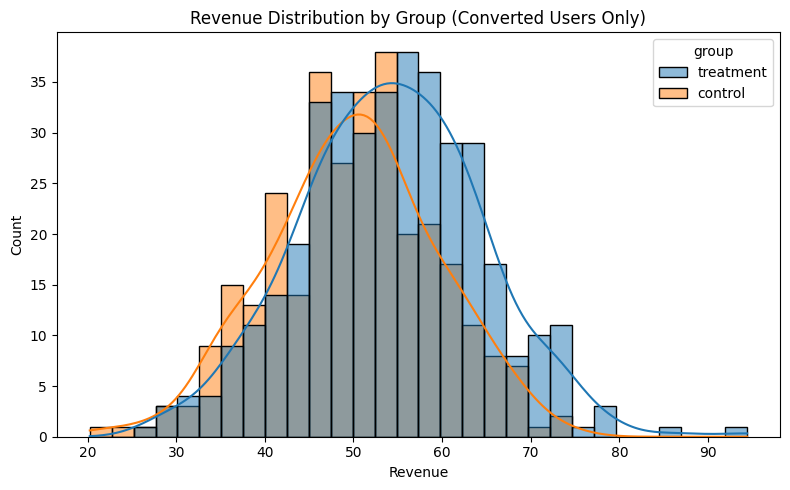

In [3]:
# Revenue statistics by group
revenue_stats = df.groupby('group')['revenue'].agg(['mean', 'median', 'std'])
print("\nRevenue statistics by group:\n", revenue_stats)

# Trial-to-paid conversion by group
trial_paid = df[df['converted']].groupby('group')['trial_to_paid'].mean()
print("\nTrial-to-paid rate among converted users:\n", trial_paid)

# Optional: Distribution plot for revenue
plt.figure(figsize=(8, 5))
sns.histplot(data=df[df['converted']], x='revenue', hue='group', kde=True, bins=30)
plt.title("Revenue Distribution by Group (Converted Users Only)")
plt.xlabel("Revenue")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [4]:
# Step 2: Statistical Testing

# A. Z-Test for conversion rate difference
success_counts = df.groupby('group')['converted'].sum().values
n_obs = df.groupby('group')['converted'].count().values
z_stat, p_value = proportions_ztest(count=success_counts, nobs=n_obs)
print(f"\nZ-Test for Conversion Rate:\nZ-Statistic = {z_stat:.4f}, P-Value = {p_value:.4f}")




Z-Test for Conversion Rate:
Z-Statistic = -3.0868, P-Value = 0.0020


In [7]:
# B. Confidence Intervals for Conversion Rate
def proportion_confint(success, total, alpha=0.05):
    p = success / total
    z = stats.norm.ppf(1 - alpha / 2)
    se = np.sqrt(p * (1 - p) / total)
    return (p - z * se, p + z * se)

for group in ['control', 'treatment']:
    total = df[df['group'] == group].shape[0]
    success = df[df['group'] == group]['converted'].sum()
    ci_low, ci_high = proportion_confint(success, total)
    print(f"\n{group.title()} Conversion Rate CI: ({ci_low:.3f}, {ci_high:.3f})")




Control Conversion Rate CI: (0.109, 0.135)

Treatment Conversion Rate CI: (0.138, 0.166)


In [8]:
# C. Confidence Intervals for Average Revenue (converted only)
converted_revenue = df[df['converted']]
for group in ['control', 'treatment']:
    revenue_data = converted_revenue[converted_revenue['group'] == group]['revenue']
    mean = revenue_data.mean()
    sem = stats.sem(revenue_data)
    ci = stats.t.interval(0.95, len(revenue_data)-1, loc=mean, scale=sem)
    print(f"\n{group.title()} Avg Revenue CI (converted users): ({ci[0]:.2f}, {ci[1]:.2f})")



Control Avg Revenue CI (converted users): (48.87, 50.99)

Treatment Avg Revenue CI (converted users): (53.20, 55.28)


In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Step 3: Logistic Regression Analysis

# Encode categorical variables and ensure target is integer
df['converted'] = df['converted'].astype(int)
df_encoded = pd.get_dummies(df, columns=['group', 'device', 'source'], drop_first=True, prefix=['group', 'device', 'source'])

# Check column names
print("\nEncoded columns:", df_encoded.columns.tolist())

# Identify actual column names for modeling
available_columns = df_encoded.columns.tolist()
predictors = [col for col in available_columns if col.startswith(('group_', 'device_', 'source_')) and col != 'group_control']
formula = 'converted ~ ' + ' + '.join(predictors)

# Logistic regression model using actual column names
model = smf.logit(formula, data=df_encoded)
result = model.fit()

# Summary of logistic regression
print("\nLogistic Regression Results:\n")
print(result.summary())


Encoded columns: ['user_id', 'converted', 'revenue', 'trial_to_paid', 'group_treatment', 'device_mobile', 'device_tablet', 'source_organic', 'source_referral']
Optimization terminated successfully.
         Current function value: 0.398697
         Iterations 6

Logistic Regression Results:

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4994
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Apr 2025   Pseudo R-squ.:                0.002877
Time:                        03:30:19   Log-Likelihood:                -1993.5
converged:                       True   LL-Null:                       -1999.2
Covariance Type:            nonrobust   LLR p-value:                   0.04224
                              coef    std err          z      P>|z|      [

In [13]:
# Step 4: Linear Regression on Revenue (Converted Users Only)
converted_only = df_encoded[df_encoded['converted'] == 1].copy()

# Define formula for linear regression
revenue_predictors = [col for col in predictors if col in converted_only.columns]
revenue_formula = 'revenue ~ ' + ' + '.join(revenue_predictors)

# Fit the linear regression model
revenue_model = smf.ols(formula=revenue_formula, data=converted_only).fit()

# Output regression summary
print("\nLinear Regression on Revenue (Converted Users Only):\n")
print(revenue_model.summary())



Linear Regression on Revenue (Converted Users Only):

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     7.031
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           2.03e-06
Time:                        03:31:31   Log-Likelihood:                -2546.1
No. Observations:                 686   AIC:                             5104.
Df Residuals:                     680   BIC:                             5131.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------